# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [2]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [4]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$

$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [39]:
def __apk(relevant: List[List[int]], predicted: [List[List[int]]], k: int) -> float:
    if len(predicted) > k:
        predicted = predicted[:k]
        
    score = 0.0
    num_hits = 0.0

    for index, pred in enumerate(predicted):
        if pred in relevant and pred not in predicted[:index]:
            num_hits += 1.0
            score += num_hits / (index + 1.0)
    
    return score / min(len(relevant), k)


def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20) -> float:
    n = len(relevant)
    return sum(
        [__apk(rel, pred, k) for rel, pred in zip(relevant, predicted)]
    ) / n

In [40]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

print(round(mapk(relevant, pred, k=5), 4))

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

0.4331


Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [41]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [42]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [43]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [44]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [45]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [46]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [47]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [48]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (1 балл).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [98]:
from scipy.sparse import csr_matrix

In [99]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame, is_sparse: bool = False):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
        if is_sparse:
            self.R = csr_matrix(self.R)

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int) -> List[List[int]]:
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int) -> List[List[int]]:
        """
        param k: int
        return: [n_users, k] - recommended k items without repeating 
        """
        test_preds = []
            
        for i in range(self.n_users):
            test_preds.append(self.recommend(i))
            
        test_preds = self.remove_train_items(test_preds, k)

        return test_preds[test_users]

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (1 балл).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [100]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    similarity = ratings @ user_vector
    
    ratings_squares = np.sum(ratings ** 2, axis=1)
    user_vector_squares = np.sum(user_vector ** 2)
    
    norm = np.sqrt(ratings_squares * user_vector_squares)
    
    pearson_correlation = similarity / norm
    
    return pearson_correlation

In [101]:
def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    intersection = ratings @ user_vector

    ratings_sum = ratings.sum(axis=1)
    user_vector_sum = user_vector.sum()

    union = ratings_sum + user_vector_sum - intersection

    return intersection / union

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [110]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func, is_sparse: bool = False):
        super().__init__(ratings, is_sparse)

        # assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        similarity = self.similarity(self.R[uid])
        
        N = np.argwhere(similarity > self.alpha)[:, 0]
        
        predictions = (similarity[N] @ self.R[N]) / np.sum(similarity[N])
        
        return np.argsort(predictions)[::-1]

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [111]:
def random_prediction():
    unique_users = np.unique(train_ratings['userId'])
    return np.asarray(
        [tracks_info.sample(50)['id'] for _ in range(len(unique_users))]
    )

In [112]:
pearson_model = User2User(train_ratings, pearson)

In [113]:
jaccard_model = User2User(train_ratings, jaccard)

In [106]:
def test_predictions(pearson_model: BaseModel, jaccard_model: BaseModel):
    k_range = range(1, 15)

    mapk_pearson = []
    mapk_jaccard = []
    mapk_random = []

    random_predictions = random_prediction()

    for k in k_range:
        pearson_prediction = pearson_model.get_test_recommendations(k)
        jaccard_prediction = jaccard_model.get_test_recommendations(k)

        pearson_mapk = mapk(test_relevant, pearson_prediction, k)
        jaccard_mapk = mapk(test_relevant, jaccard_prediction, k)
        random_mapk = mapk(test_relevant, random_predictions, k)
    
        mapk_pearson.append(pearson_mapk)
        mapk_jaccard.append(jaccard_mapk)
        mapk_random.append(random_mapk)

    plt.plot(mapk_pearson, label='pearson')
    plt.plot(mapk_jaccard, label='jaccard')
    plt.plot(mapk_random, label='random')
    plt.legend()
    plt.show()

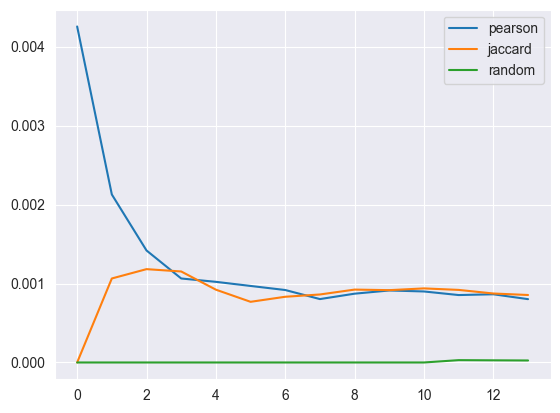

In [92]:
test_predictions(pearson_model, jaccard_model)

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

Собственно, я написал новые **sparse-** функции и изменил `BaseModel` (добавил преобразование `self.R` в sparse-матрицу при помощи `scipy.csr_matrix`, если выставлен флажок `is_sparse`)

In [114]:
def sparse_pearson(ratings: csr_matrix, user_vector: csr_matrix) -> np.array:
    user_vector = user_vector.T if user_vector.shape[0] == 1 else user_vector
    
    similarity = ratings.dot(user_vector).toarray().flatten()
    
    ratings_norms = np.sqrt(ratings.multiply(ratings).sum(axis=1)).A.flatten()
    user_vector_norm = np.sqrt(user_vector.multiply(user_vector).sum())
    
    pearson_correlation = similarity / (ratings_norms * user_vector_norm)
    
    return pearson_correlation

In [115]:
def sparse_jaccard(ratings: csr_matrix, user_vector: csr_matrix) -> np.array:
    user_vector = user_vector.T if user_vector.shape[0] == 1 else user_vector
    
    intersection = ratings.dot(user_vector).toarray().flatten()
    
    ratings_sum = ratings.sum(axis=1).A.flatten()
    user_vector_sum = user_vector.sum()
    
    union = ratings_sum + user_vector_sum - intersection
    
    return intersection / union

In [116]:
pearson_sparse_model = User2User(train_ratings, sparse_pearson, is_sparse=True)

In [117]:
jaccard_sparse_model = User2User(train_ratings, sparse_jaccard, is_sparse=True)

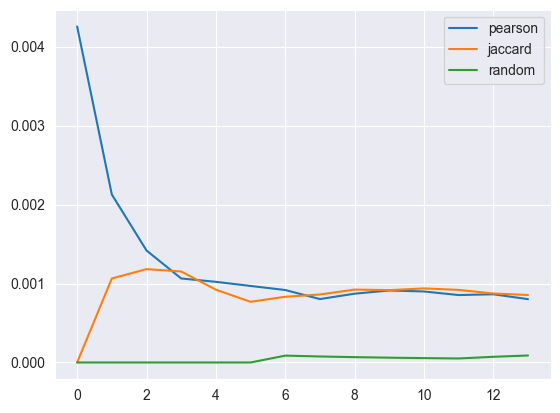

In [118]:
test_predictions(pearson_sparse_model, jaccard_sparse_model)

DataSpell показывает, что на обучение с обычными матрицами уходит 212 секунд. А на обучение со sparse-матрицами уходит 18 секунд. Прирост скорости почти в 12 раз :)

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [119]:
user_id = np.random.randint(0, pearson_sparse_model.n_users)

In [120]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
57,I Want You Back,['The Jackson 5']
226,Lovefool,['The Cardigans']
233,Breakfast At Tiffany's,['Deep Blue Something']
329,Mas Que Nada,"['Sergio Mendes', 'Black Eyed Peas']"
333,You Give Me Something,['James Morrison']
354,Dancing Queen,['ABBA']
655,Mr Sandman,['The Puppini Sisters']
741,I'm Coming Out,['Diana Ross']
761,Unchained Melody,['The Righteous Brothers']
1117,The Lady In Red,['Chris De Burgh']


In [121]:
preds = pearson_sparse_model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
11493,The Show Must Go On,['Queen']
24500,Way Down We Go,['KALEO']
11950,Somebody That I Used To Know,"['Gotye', 'Kimbra']"
805,Zombie,['The Cranberries']
7533,Highway to Hell,['AC/DC']
2481,Gangsta's Paradise,"['Coolio', 'L.V.']"
6376,"You're Gonna Go Far, Kid",['The Offspring']
8263,Shape Of My Heart,['Sting']
6448,Sweet Dreams (Are Made of This),"['Eurythmics', 'Annie Lennox', 'Dave Stewart']"
7780,ИСКАЛА,['Земфира']


Ну на самом деле не все так плохо, мне кажется. Земфира только непонятно откуда взялась, но она на последнем месте, ладно

In [123]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
34891,There's Nothing Holdin' Me Back,['Shawn Mendes']
35947,Королева красоты,['Муслим Магомаев']
35986,Малыш,['Мумий Тролль']
36210,До свидания...,['Земфира']
36481,idontwannabeyouanymore,['Billie Eilish']
37037,Videli Noci,['Zdob si Zdub']
37877,Mi Gente,"['J. Balvin', 'Willy William', 'Beyoncé']"
38354,DuckTales,['Ксения Ишкина']
38673,Песня безумца,"['Лев Кошкаров', 'Виктор Киричёк']"
39152,Perfect Duet,"['Ed Sheeran', 'Beyoncé']"


### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

### Алгоритм обучения **LFM:**

Пусть у нас есть оценка $\hat{r}_{ui} = \langle p_u, q_u \rangle,$

$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Берем наш функционал ошибки:

$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

И оптимизируем таким образом:

1) Заполняем матрицы *P* и *Q* случайными значениями
2) Выбираем случайную пару юзера **u** из матрицы *P* и айтема **i** из матрицы *Y*
3) Считаем градиенты:

$$
\begin{equation*}
\begin{cases}
p_u \leftarrow p_u + \eta \cdot \left( e_{ui} \cdot q_i - \lambda \cdot p_u \right) \\
q_i \leftarrow q_i + \eta \cdot \left( e_{ui} \cdot p_u - \lambda \cdot q_i \right)
\end{cases}, 
\quad e_{ui} = r_{ui} - \hat{r}_{ui}
\end{equation*}
$$

4) Делаем несколько таких итераций (примерно сотню)

### Алгоритм обучения **ALS:**

В **ALS** функционал ошибки выглядит чуть по-другому: 

\begin{equation*}
L = \sum c_{ui} \left(p_{ui} - p^T_{ui} \cdot q_i \right)^2 + \lambda \left( \sum \| p_u \|^2 + \sum \| q_i \|^2 \right) \rightarrow \min
\end{equation*}

где 
\begin{equation*}
p_{ui} =
\begin{cases}
1, & r_{ui} > 0 \\
0, & \text{otherwise}
\end{cases}
\quad \text{-- индикатор совершенного действия}
\end{equation*}

\begin{equation*}
c_{ui} =
\begin{cases}
1 + \alpha \cdot r_{ui}, & r_{ui} > 0 \\
1, & \text{otherwise}
\end{cases}
\quad \text{-- уверенность в данном действии}
\end{equation*}

Далее оптимизируем его:

1) Так как у нас есть все элементы матрицы, мы можем на один шаг положить одну из матриц константной и решать оптимизационную задачу только с одной из матриц 

$$
\begin{equation*}
\begin{cases}
p_u = (Q^T \cdot C^u \cdot Q + \lambda \cdot I)^{-1} \cdot Y^T \cdot C^u \cdot p(u) \\
q_i = (P^T \cdot C^i \cdot P + \lambda \cdot I)^{-1} \cdot P^T \cdot C^i \cdot q(i)
\end{cases}, 
\end{equation*}
$$

$\quad C^u, C^i $ - диагональные матрицы размера $ u*u, i*i, C^u_{ii} = c_{ui}, C^i_{uu} = c_{ui} $

2) Попеременно считая X и Y за константу, находим аналитическим образом оптимальные значения для X и Y

**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [ ]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                pass

            elif self.mode == 'als':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                pass

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [ ]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [ ]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
5517,Варвара,['Би-2'],0.649796
17328,Я хочу быть с тобой,['Nautilus Pompilius'],0.646846
2058,Последний герой,['КИНО'],0.640997
5872,Я свободен,['Кипелов'],0.606749
2060,Хочу перемен,['КИНО'],0.603231
5515,Романс,['Сплин'],0.590318
24284,Как на войне,['Агата Кристи'],0.586219
4463,Holiday,['Green Day'],0.576644
2179,Восьмиклассница,['КИНО'],0.570639
